<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/Hw1_Skip_Gram_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# HW1: Skip-Gram Model From Scratch

In [1]:
%matplotlib inline
# put your student name here, you will need to train the model that prints out your name in each loss
# without the name, you will not be able to get points in train part
STUDENT_NAME = "Shubham Derhgawen"

This section imports necessary Python libraries such as NumPy and the random module. These libraries are essential for generating random training data and managing numerical computations.

In [2]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)

### 1.Create Corpus

In this section, you should first define a custom vocabulary composed of universities in Southern California (SoCal) and Northern California (NorCal). It generates a synthetic corpus by randomly pairing elements within each regional list to simulate word-context relationships.

In [3]:
SoCal = ["UCR", "UCLA", "UCSD", "UCI", "UCSB"]
NorCal = ["UCB", "UCSC", "UCD", "UCSF", "UCM"]
vocab = SoCal + NorCal

corpus = []

# Create Corpus
for i in range(20):
  random.shuffle(SoCal)
  corpus.append((SoCal[0], SoCal[1]))

for i in range(20):
  random.shuffle(NorCal)
  corpus.append((NorCal[0], NorCal[1]))

word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

vocab_size = len(vocab)

embedding_dim = 2
learning_rate = 0.02
num_neg_samples = 2

print(corpus)

[('UCSD', 'UCLA'), ('UCSD', 'UCR'), ('UCR', 'UCSD'), ('UCI', 'UCR'), ('UCR', 'UCSB'), ('UCSB', 'UCLA'), ('UCLA', 'UCSB'), ('UCI', 'UCLA'), ('UCI', 'UCSB'), ('UCLA', 'UCSB'), ('UCR', 'UCI'), ('UCI', 'UCLA'), ('UCI', 'UCR'), ('UCSB', 'UCSD'), ('UCI', 'UCSD'), ('UCSD', 'UCSB'), ('UCLA', 'UCSD'), ('UCSB', 'UCLA'), ('UCR', 'UCI'), ('UCLA', 'UCSD'), ('UCSF', 'UCD'), ('UCB', 'UCD'), ('UCM', 'UCSC'), ('UCM', 'UCD'), ('UCSF', 'UCB'), ('UCB', 'UCSC'), ('UCSC', 'UCD'), ('UCSC', 'UCB'), ('UCB', 'UCSF'), ('UCSF', 'UCD'), ('UCM', 'UCSC'), ('UCSC', 'UCD'), ('UCM', 'UCSC'), ('UCD', 'UCM'), ('UCM', 'UCB'), ('UCB', 'UCD'), ('UCM', 'UCB'), ('UCB', 'UCD'), ('UCB', 'UCSC'), ('UCSF', 'UCB')]


### 2.Define Visualization Function

Implement plotting utilities for visualizing training loss, embedding space, and cosine similarity between word vectors. (No Need to Change.)


In [4]:
import matplotlib.pyplot as plt

# Plot loss over epochs
def plot_loss_over_epochs(loss_values, epochs):
  plt.figure(figsize=(6, 4))
  plt.plot(range(1, epochs + 1), loss_values, marker='o')
  plt.ticklabel_format(style='plain', axis='y', useOffset=False)
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.title('Loss over Epochs')
  plt.show()

# Plot Embedding
def plot_embedding(matrix, vocab):
  plt.figure(figsize=(6, 4))
  x = matrix[:, 0]
  y = matrix[:, 1]
  plt.scatter(x, y)
  for i, word in enumerate(vocab):
    plt.annotate(word, xy=(x[i], y[i]))

  plt.title("Embedding Visualization")
  plt.show()

# Plot Similary score
def plot_cosine_similarity(matrix, vocab):

  def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

  similarities = np.array([
      cosine_similarity(matrix[0], emb) for emb in matrix
  ])

  plt.figure(figsize=(6, 4))
  plt.bar(range(len(similarities)), similarities)
  plt.xticks(range(len(similarities)), vocab)
  plt.ylim(-1.1, 1.1)
  plt.ylabel("Cosine Similarity")
  plt.title("Cosine Similarity to UCR")
  plt.grid(axis='y')

  plt.show()

### 3.Define trainable parameters (10pt)

Use Numpy to initialize two trainable embedding matrices — one for context words and one for target words — with small random values.

Here is the size for each Matrix:

1. Context Matrix:   [vocab_size, embedding_dim]
2. Target Matrix:  [vocab_size, embedding_dim]

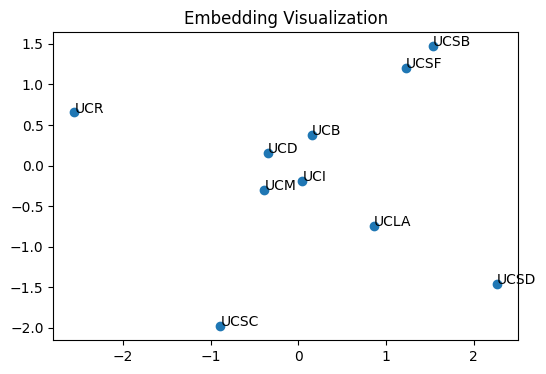

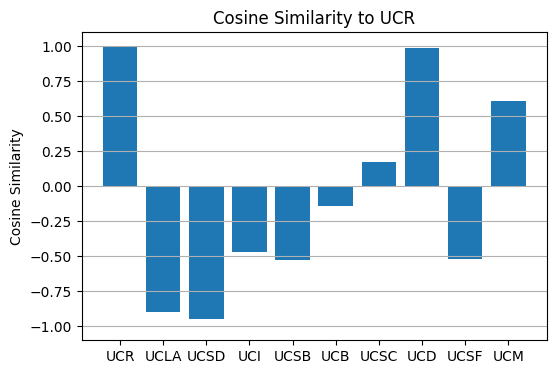

In [5]:
def initialize_parameters(vocab_size, embedding_dim):
  # Context Matrix
  ####! add your code here
  W1 = np.random.randn(vocab_size, embedding_dim)
  ####

  # Target Matrix
  ####! add your code here
  W2 = np.random.randn(vocab_size, embedding_dim)
  ####

  return W1, W2

# visualization
W1, W2 = initialize_parameters(vocab_size, embedding_dim)
plot_embedding(W2, vocab)
plot_cosine_similarity(W2, vocab)

### 4.Define Activation Function (5pt)
Implement the sigmoid function used in the computation of prediction probabilities and gradients.


Sigmoid Function: $\sigma(z) = \frac{1}{ 1 + exp(-z)}$

In [6]:
#! define sigmoid function
def sigmoid(z):
  z = np.clip(z, -100, 100)
  ####! add your code here
  z = 1 / (1 + np.exp(-z))
  return z

### 5.Define Negative Sampling (15pt)

Randomly select a set of negative word samples for each training instance, ensuring they differ from the current positive pair.

By using negative sampling, we can improve computational efficiency by approximating the full softmax over the vocabulary.


In [7]:
def negative_sampling(word_to_index, target_index, context_index, num_neg_samples):
  """
  word_to_index: vocabulary.
  target_index: target word index.
  num_neg_samples: numbers of negative samples.
  """
  vocab_indices = list(word_to_index.values())
  # remove context and target tokens.
  ####! add your code here
  filtered_indices = [idx for idx in vocab_indices if idx != target_index and idx != context_index]


  ####
  # randomly choose negative words.
  ####! add your code here
  neg_samples = random.sample(filtered_indices, num_neg_samples)
  ####

  return neg_samples


# test Negative Sampling
neg_samples = negative_sampling(word_to_index, word_to_index["UCR"], word_to_index["UCLA"], num_neg_samples)
print('Negative Words:')
for sample in neg_samples:
  print(index_to_word[sample])

Negative Words:
UCSD
UCSF


### 6.Forward (20pt)
Compute the positive and negative prediction scores and calculate the loss using the negative sampling technique.

Loss Function:
$L_{CE}=-\bigg[log\sigma(c_{pos}\cdot w) + \sum_{i=1}^{k}log\sigma(-c_{neg_i}\cdot w)\bigg]$

In [8]:
def forward_negative_sampling(context_word_index, target_word_index, neg_samples, W1, W2):
  # obtain context vector
  h_context = W1[context_word_index]
  # obtain negative sample vector
  ####! Add your code here
  h_neg = W2[neg_samples]
  ####

  # ompute positive prediction and loss.
  u_target = np.dot(h_context, W2[target_word_index])
  ####! Add your code here
  pos_loss = -np.log(sigmoid(u_target))
  ####

  # compute negative prediction and loss.
  ####! Add your code here
  u_neg_samples = np.dot(h_neg, h_context)
  neg_loss = -np.sum(np.log(sigmoid(-u_neg_samples)))
  ####

  # total loss
  loss = pos_loss + neg_loss
  return u_target, u_neg_samples, loss

### 7.Backward (20pt)
Update model parameters using gradients derived from the loss function for both positive and negative samples.

Loss Function:

1. $c^{t+1}_{pos} = c^t_{pos} - \eta [\sigma(c^t_{pos}\cdot w^t)-1]w^t$

2. $c^{t+1}_{neg} = c^t_{neg} - \eta [\sigma(c^t_{neg}\cdot w^t)]w^t$

3. $w^{t+1} = w^t - \eta \bigg[ [\sigma (c_{pos} \cdot w^t - 1)]c_{pos} + \sum_{i=1}^{k}[\sigma (c_{neg_i}\cdot w^t)] c_{neg_i}\bigg]$

In [9]:
def backward_negative_sampling(
      u_target,
      u_neg_samples,
      context_word_index,
      target_word_index,
      neg_samples_idx,
      W1,
      W2,
      learning_rate):
  """
  u_target: positive prediction.
  u_negative_samples: negative predictions.
  target_word_index: positive prediction word.
  neg_samples_idx: negative prediction words.
  W1: Embedding matrix.
  W2: Projection matrix.
  """
  # positive gradient.
  grad_pos = sigmoid(u_target) - 1
  W2[target_word_index] -= learning_rate * grad_pos * W1[context_word_index]
  ####! Add your code here
  W1[context_word_index] -= learning_rate * grad_pos * W2[target_word_index]
  ####

  # negative gradient.
  ####! Add your code here
  grad_neg = sigmoid(u_neg_samples)
  ####

  for i, neg_index in enumerate(neg_samples_idx):
      ####! Add your code here
      W2[target_word_index] -= learning_rate * grad_neg[i] * W1[context_word_index]
      W1[neg_index] -= learning_rate * grad_neg[i] * W2[neg_index]
      ####

### 8.Train Skip-Gram Model (20pt)

Loop through the corpus over multiple epochs, applying forward and backward passes to learn word embeddings. You can train the model to produce meaningful word embeddings that capture contextual similarities.


In [10]:
def train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples):
  """
  corpus: Training corpus.
  word_to_index: vocabulary.
  vocab_size: Size of vocabulary.
  embedding_dim: Dimension of Embedding matrix.
  learning_rate: learning rate for optimization.
  epochs: Training epochs.
  num_neg_samples: numbers of negative samples used during training.
  """
  # init parameters
  W1, W2 = initialize_parameters(vocab_size, embedding_dim)
  total_loss = []
  for epoch in range(epochs):
      loss_epoch = 0
      for context_word, target_word in corpus:

          # convert to index.
          context_word_index = word_to_index[context_word]
          target_word_index = word_to_index[target_word]

          # Obtain negative samples.
          ####! Add your code here
          neg_samples_index = negative_sampling(word_to_index, target_word_index, context_word_index, num_neg_samples)
          ####

          # Forward
          ####! Add your code here
          u_target, u_neg_samples, loss = forward_negative_sampling(context_word_index, target_word_index, neg_samples_index, W1, W2)
          ####
          loss_epoch += loss

          # Backward
          ####! Add your code here
          backward_negative_sampling(
            u_target,
            u_neg_samples,
            context_word_index,
            target_word_index,
            neg_samples_index,
            W1,
            W2,
            learning_rate)


          ####

      avg_loss = loss_epoch / len(corpus)
      print(f"{STUDENT_NAME} Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")
      total_loss.append(avg_loss)

  return W1, W2, total_loss

### 9.Run Skip-Gram Model

Executes the training process and visualizes the final word embeddings.




Shubham Derhgawen Epoch 1/10, Loss: 2.3572481297345145
Shubham Derhgawen Epoch 2/10, Loss: 2.6487144979969486
Shubham Derhgawen Epoch 3/10, Loss: 2.7754638403109513
Shubham Derhgawen Epoch 4/10, Loss: 2.4306024629551795
Shubham Derhgawen Epoch 5/10, Loss: 2.2626519714667985
Shubham Derhgawen Epoch 6/10, Loss: 2.285002765367063
Shubham Derhgawen Epoch 7/10, Loss: 2.4462435729183434
Shubham Derhgawen Epoch 8/10, Loss: 2.3172199723942626
Shubham Derhgawen Epoch 9/10, Loss: 2.376855377454782
Shubham Derhgawen Epoch 10/10, Loss: 2.126896629078689


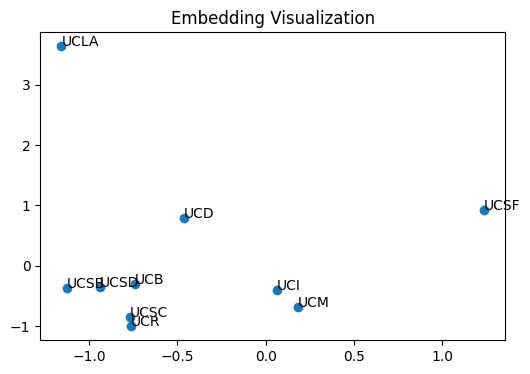

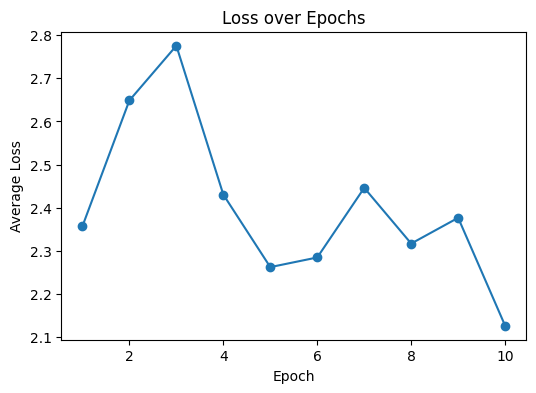

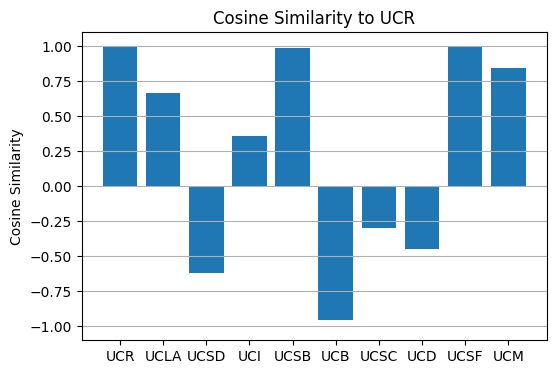

In [11]:
epochs = 10
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

Shubham Derhgawen Epoch 1/100, Loss: 3.5096593916576153
Shubham Derhgawen Epoch 2/100, Loss: 3.493416527199547
Shubham Derhgawen Epoch 3/100, Loss: 3.2633407087253863
Shubham Derhgawen Epoch 4/100, Loss: 3.29511462308977
Shubham Derhgawen Epoch 5/100, Loss: 3.024552151147229
Shubham Derhgawen Epoch 6/100, Loss: 3.5386852772248574
Shubham Derhgawen Epoch 7/100, Loss: 3.174434980950602
Shubham Derhgawen Epoch 8/100, Loss: 3.0864268774806027
Shubham Derhgawen Epoch 9/100, Loss: 3.0813400462166163
Shubham Derhgawen Epoch 10/100, Loss: 3.5731062041341395
Shubham Derhgawen Epoch 11/100, Loss: 3.202043807010829
Shubham Derhgawen Epoch 12/100, Loss: 3.3271437421018666
Shubham Derhgawen Epoch 13/100, Loss: 3.245685790306802
Shubham Derhgawen Epoch 14/100, Loss: 3.4286685340539123
Shubham Derhgawen Epoch 15/100, Loss: 3.4895433703718908
Shubham Derhgawen Epoch 16/100, Loss: 3.5274167570723245
Shubham Derhgawen Epoch 17/100, Loss: 3.4074231095364764
Shubham Derhgawen Epoch 18/100, Loss: 3.7564997

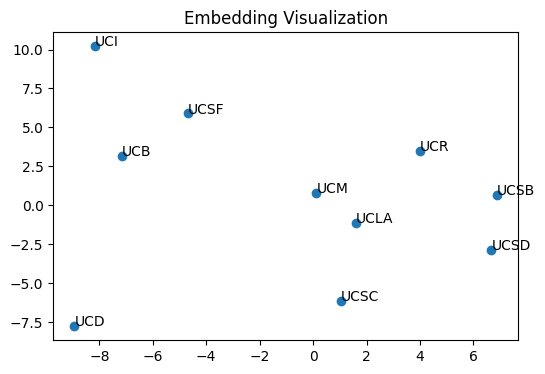

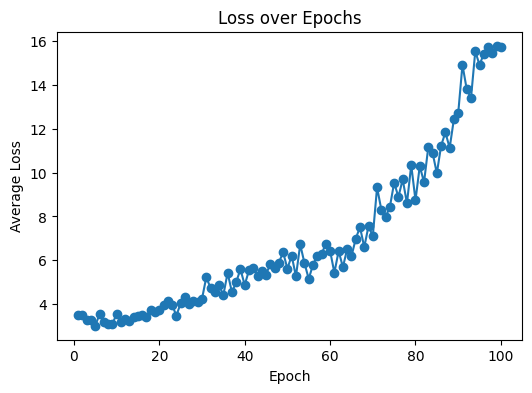

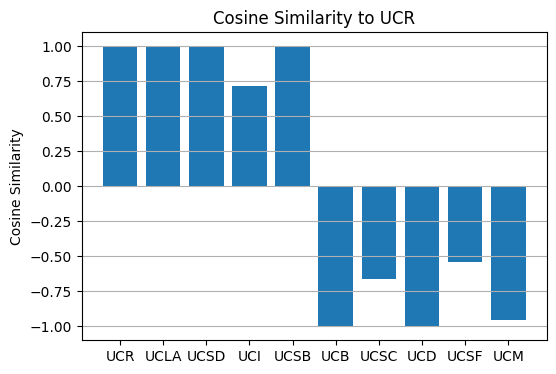

In [12]:

epochs = 100
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

Shubham Derhgawen Epoch 1/200, Loss: 2.4512430025905227
Shubham Derhgawen Epoch 2/200, Loss: 2.3945893406717733
Shubham Derhgawen Epoch 3/200, Loss: 2.4072467521406398
Shubham Derhgawen Epoch 4/200, Loss: 2.3299279160484856
Shubham Derhgawen Epoch 5/200, Loss: 2.483361953925737
Shubham Derhgawen Epoch 6/200, Loss: 2.302930783774703
Shubham Derhgawen Epoch 7/200, Loss: 2.273321506074934
Shubham Derhgawen Epoch 8/200, Loss: 2.5564275900299562
Shubham Derhgawen Epoch 9/200, Loss: 2.5925501739219547
Shubham Derhgawen Epoch 10/200, Loss: 2.500652762256304
Shubham Derhgawen Epoch 11/200, Loss: 2.6588365495081536
Shubham Derhgawen Epoch 12/200, Loss: 2.5554130555009076
Shubham Derhgawen Epoch 13/200, Loss: 2.322291574561126
Shubham Derhgawen Epoch 14/200, Loss: 2.5343528941555906
Shubham Derhgawen Epoch 15/200, Loss: 2.6333379084425768
Shubham Derhgawen Epoch 16/200, Loss: 2.9003990012815595
Shubham Derhgawen Epoch 17/200, Loss: 2.5279047309053846
Shubham Derhgawen Epoch 18/200, Loss: 2.61626

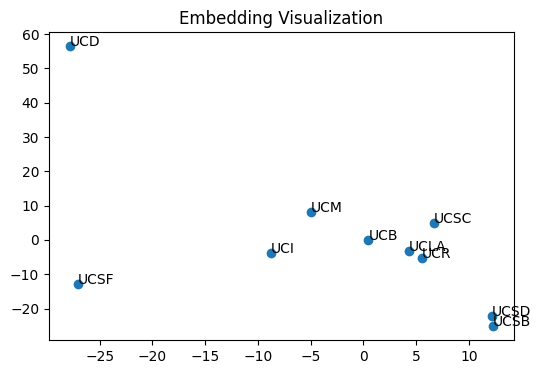

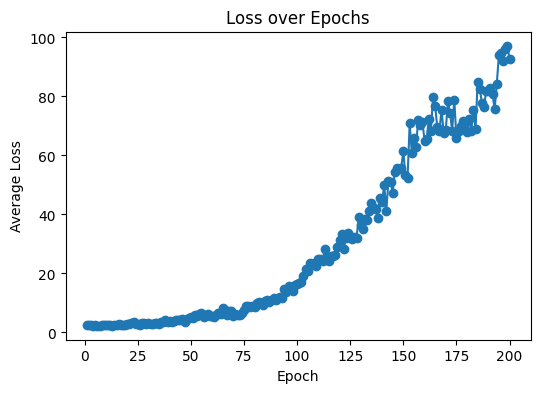

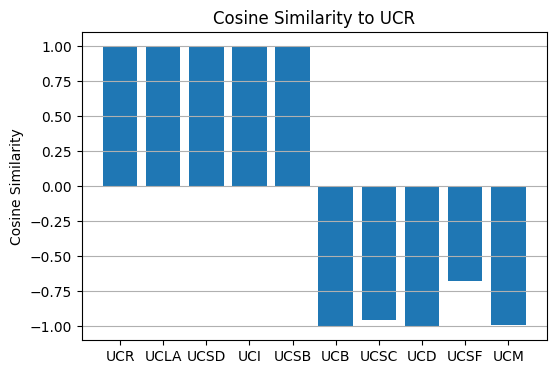

In [13]:
epochs = 200
W1, W2, total_loss = train_skip_gram_negative_sampling(corpus, word_to_index, vocab_size, embedding_dim, learning_rate, epochs, num_neg_samples)
plot_embedding(W1, vocab)
plot_loss_over_epochs(total_loss, epochs)
plot_cosine_similarity(W2, vocab)

### 10.Use Pre-trained Word2Vector Model (10pt)

In this section, you should use pretrained GloVe word embeddings from the gensim library to compute the semantic similarity between sentences.



In [ ]:
!pip install -U gensim
import os
os.kill(os.getpid(),9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
from nltk.tokenize import word_tokenize
import gensim.downloader
import nltk
import string
from nltk.corpus import stopwords

nltk.download('punkt_tab')
nltk.download('stopwords')

# List all pretrained embedding models
print(list(gensim.downloader.info()['models'].keys()))

# Download the "glove-twitter-25" embeddings
models = gensim.downloader.load('glove-twitter-25')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 104.8/104.8MB downloaded


In [2]:
def review_to_vector(review_text):
    # Tokenize and clean the review
    words = word_tokenize(review_text.lower())
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stopwords.words('english')]

    # Remove words not in vocabulary
    ####! Add your code here
    valid_words = [word for word in words if word in models.key_to_index]

    ####
    if not valid_words:
        return np.zeros(models.vector_size)

    # Average word vectors
    ####! Add your code here
    word_vectors = [models[word] for word in valid_words]
    avg_vec =np.mean(word_vectors, axis=0)
    ####
    return avg_vec

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [3]:
# Three Sentences.
sent1 = "The cat is sleeping on the sofa."
sent2 = "A cat is napping on the couch."
sent3 = "The spaceship landed on Mars after a six-month journey."

# Convert reviews to vectors
vec1 = review_to_vector(sent1)
vec2 = review_to_vector(sent2)
vec3 = review_to_vector(sent3)

# Calculate similarities
sim1 = cosine_similarity(vec1, vec2)
sim2 = cosine_similarity(vec1, vec3)

print(f"sent1-sent2 similarity: {sim1:.4f}")
print(f"sent1-sent3 similarity: {sim2:.4f}")

sent1-sent2 similarity: 0.9441
sent1-sent3 similarity: 0.6561
